## Семинар 6. Теория вероятности.

### Что было на лекции

Вероятность — функция P, определенная на событиях. Значение функции отражает представление о том, с какой вероятностью данное событие случается: 0 - не случается вовсе, 1 - случается всегда.

### Дискретные случайные величины

Распределение Бернулли:

$\xi = 1$ — успех (выпадение орла/правильный ответ на вопрос и пр.)

$\xi \sim Ber(p)$

$P(\xi = 1) = p$

In [134]:
import numpy as np
import pandas as pd
import scipy as sp

import pylab as plt

%matplotlib inline

In [135]:
def plot_hist(sample, title, xlabel='value', ylabel='freq', bins=10):
    plt.hist(sample, bins, normed=True, facecolor='green', alpha=0.75)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

    plt.show()

In [136]:
from scipy.stats import bernoulli

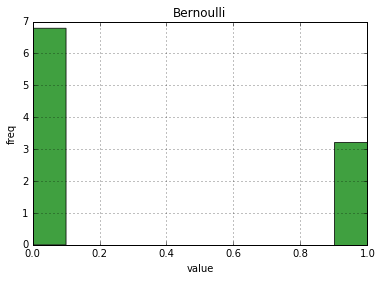

In [137]:
p = 0.3
sample = bernoulli.rvs(p, size=1000)
plot_hist(sample, 'Bernoulli')

### Биномиальное распределение

$\xi_i \sim Ber(p)$

$\eta = \sum_{i=1}^n\xi_i \sim Bin(n, p)$

$P(\eta = k) = C^n_kp^k(1-p)^{n-k}$

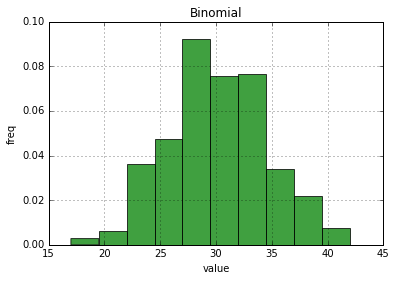

In [138]:
n, p = 100, .3
sample = np.random.binomial(n, p, 1000)
plot_hist(sample, 'Binomial')

### Распределение Пуассона

$\xi_i$ — количество раз некоторого редкого события (встретить слово в тексте)

$P(\xi_i = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \lambda > 0$

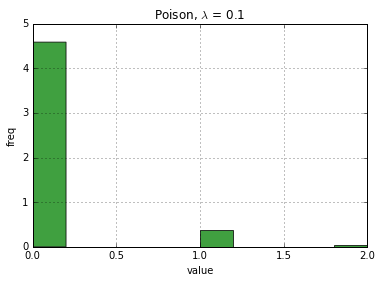

In [139]:
sample = np.random.poisson(0.1, 1000)
plot_hist(sample, 'Poison, $\lambda$ = 0.1')

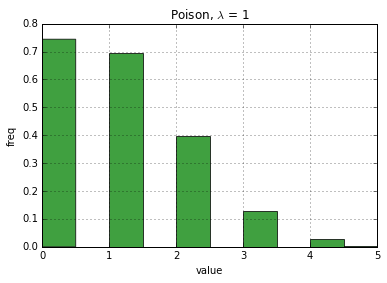

In [140]:
sample = np.random.poisson(1, 1000)
plot_hist(sample, 'Poison, $\lambda$ = 1')

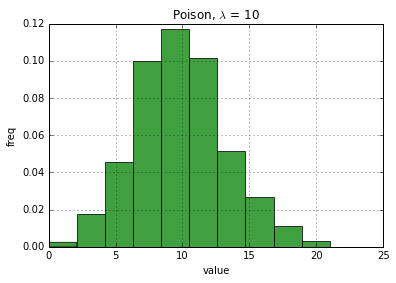

In [141]:
sample = np.random.poisson(10, 1000)
plot_hist(sample, 'Poison, $\lambda$ = 10')

**Независимые события**

События A и B называются независимыми, если выполнено соотношение:

$P(AB) = P(A)P(B)$

где P(AB) — вероятность что произошло и A и B.

Определение продолжается очевидным образом: n событий $A_1,...,A_n$ называются независимыми, если выполнено

$P(A_1,...,A_n) = P(A_1) \cdots P(A_n)$

**Условная вероятность**

Допустим есть два события: A и B. Если известно, что B произошло, то вероятность A можно вычислить по формуле:

$P(A|B) = \dfrac{P(AB)}{P(B)}$

Отсюда получаем что 

$P(AB) = P(A|B)P(B)$ или $P(AB) = P(B|A)P(A)$

Отсюда получаем **формулу Байеса**

$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$

*Как из этого построить классификатор?*

Пусть у нас есть некоторая обучающая выборка: $X^l = (x_i, y_i)_{i=1}^l$

Будем считать что событие A — "объект принадлежит классу $\dot{y}$", а событие B — "объект описывается набором признаков $(x^1, \cdots, x^n)$". Тогда можно переписать формулу в следующем виде:

$P(\dot{y}~|~(x^1, \cdots, x^n)) = \dfrac{P((x^1, \cdots, x^n)~|~\dot{y})P(\dot{y})}{P((x^1, \cdots, x^n))}$

А теперь сделаем "наивное" предположение: пусть все признаки независимы. Тогда:

$P(\dot{y}~|~(x^1, \cdots, x^n)) = \dfrac{\prod_j{P(x^j~|~\dot{y}})P(\dot{y})}{P(x^1, \cdots, x^n)}$

Откуда получаем сам классификатор:

$a(x) = \arg\max_{\dot{y}} P(\dot{y}~|~(x^1, \cdots, x^n)) = \arg\max_{\dot{y}} \prod_j{P(x^j~|~\dot{y}})P(\dot{y}) $

### Байесовский классификатор

$a(x) = \arg\max_{y \in Y} P(y) \prod_j P(x^j|y)$

**Небольшой спам фильтр своими руками**

Разберем работу наивного байесовского классификатора на примере. В качестве данных взяли набор sms-сообщений, нужно определить, является ли данное сообщение спамом.

Объекты — сообщения

Признаки — слова сообщения

Целевая метка — спам/не спам

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from __future__ import division

data = pd.read_csv('sms_data.txt', sep='\t', names=('label', 'text'))
data.head()

label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Разобъем выборку на 2: обучающую и тестовую

In [2]:
data = data.reindex(np.random.permutation(data.index))

data_train = data[:4000]
data_test = data[4000:]

Напишем вспомогательные функции:

In [3]:
import re

def split_message(message):
    return re.sub("[^a-zA-Z]", " ",  message.lower()).split()

split_message(data.text[0])

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [4]:
train_messages = data_train.apply(lambda row: split_message(row['text']), axis=1)
data_train.iloc[:, 1] = train_messages
test_messages = data_test.apply(lambda row: split_message(row['text']), axis=1)
data_test.iloc[:, 1] = test_messages

data_train.head()

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:499: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


label                                               text
3229  spam  [six, chances, to, win, cash, from, to, pounds...
2301   ham  [nothin, comes, to, my, mind, help, me, buy, h...
378    ham  [well, there, s, not, a, lot, of, things, happ...
5298   ham    [i, ll, hand, her, my, phone, to, chat, wit, u]
639    ham        [what, will, we, do, in, the, shower, baby]

Теперь есть две задачи:
1. Оценить по выборке $P(y)$ — вероятность класса (спам/не спам)
2. Оценить по выборке $P(x^j|y)$ — вероятность признака для данного класса (вероятность встретить некоторое слово в сообщении типа спам/не спам)

Обратите внимание, что все оценки будут вычисляться только по обучающей выборке!

In [5]:
n = data_train.shape[0]
n_spam = data_train[data_train['label'] == 'spam'].shape[0]
n_ham = data_train[data_train['label'] == 'ham'].shape[0]

p_spam = n_spam / n
p_ham = n_ham / n

print p_spam, p_ham

0.12925 0.87075


Как будем оценивать вероятности слов? 

1. Найдем все уникальные слова.
2. Для каждого слова посчитаем в скольки spam/ham-сообщениях оно встречалось
3. Посчитаем для каждого класса: $P(x^j~|~y) = \dfrac{count(x^j, x^j \in y)}{count(y)}$

Однако вычисление вероятности по нижней формуле плохо, так как если слово не встречалось в каком-либо из классов, соответствующая его вероятность будет равна 0, отсюда все выражение $P(y) \prod_j P(x^j|y)$ будет равно 0. Поэтому немного изменим нашу формулу:

$P(x^j~|~y) = \dfrac{count(x^j, x^j \in y) + \alpha}{count(y) + |V|\alpha}$

где $|V|$ — количество уникальных слов

In [6]:
from collections import defaultdict

def find_counts(data):
    spam_counts, ham_counts = defaultdict(int), defaultdict(int)
    for _, (label, message) in data.iterrows():
        if label == 'spam':
            for word in message:
                spam_counts[word] += 1
        else:
            for word in message:
                ham_counts[word] += 1
    return spam_counts, ham_counts

In [7]:
spam_counts, ham_counts = find_counts(data_train)

In [8]:
def find_probs(spam_counts, ham_counts, alpha=0.1):
    spam_probs, ham_probs = defaultdict(lambda: 1 / n_words), defaultdict(lambda: 1 / n_words)
    unique_words = np.unique(spam_counts.keys() + ham_counts.keys())
    n_words = unique_words.shape[0]
    spam_div = np.sum(spam_counts[w] for w in spam_counts) + alpha * n_words
    ham_div = np.sum(ham_counts[w] for w in ham_counts) + alpha * n_words
    for word in unique_words:
        spam_probs[word] = (spam_counts[word] + alpha) / spam_div
        ham_probs[word] = (ham_counts[word] + alpha) / ham_div
    return spam_probs, ham_probs

In [9]:
spam_probs, ham_probs = find_probs(spam_counts, ham_counts, alpha=0.1)

In [10]:
def classify(p_spam, p_ham, spam_probs, ham_probs, message):
    spam_score = p_spam * np.prod([spam_probs[word] for word in message])
    ham_score = p_ham * np.prod([ham_probs[word] for word in message])
    if spam_score > ham_score:
        return 'spam'
    return 'ham'

Итак, посчитаем качество нашего классификатора:

In [11]:
make_classify = lambda m: classify(p_spam, p_ham, spam_probs, ham_probs, m)
(data_test.label == data_test.text.apply(make_classify)).mean()

0.98409669211195927

Как часто спам оказывается помечен как обычное сообщение?

In [12]:
(((data_test.label == 'spam') & (data_test.text.apply(make_classify) == 'ham')).mean() / 
     (data_test.label == 'spam').mean())

0.069565217391304349

Что интересного можно посмотреть? Например, найдем топ10 слов, наиболее вероятных для каждого класса.

In [13]:
sorted(spam_probs.iteritems(), key=lambda x: x[1], reverse=True)[:20]

[('to', 0.03798017099506282),
 ('a', 0.02152289969092442),
 ('call', 0.020398988479910087),
 ('you', 0.01678641673022117),
 ('your', 0.014137197447115963),
 ('the', 0.011889375025087303),
 ('now', 0.011889375025087303),
 ('free', 0.011889375025087303),
 ('for', 0.011407698791795448),
 ('or', 0.0110063019307189),
 ('p', 0.010123228836350499),
 ('txt', 0.01004294946413519),
 ('u', 0.01004294946413519),
 ('is', 0.008597920764259623),
 ('have', 0.0074740095532452935),
 ('ur', 0.007393730181029984),
 ('on', 0.007313450808814675),
 ('from', 0.007152892064384056),
 ('stop', 0.006992333319953438),
 ('text', 0.006912053947738128)]

In [14]:
sorted(ham_probs.iteritems(), key=lambda x: x[1], reverse=True)[:20]

[('i', 0.04134996559177304),
 ('you', 0.027547904975138843),
 ('to', 0.02231397749411183),
 ('the', 0.01543233210239113),
 ('a', 0.015180328186637978),
 ('u', 0.014346776772992934),
 ('and', 0.012001201864828977),
 ('in', 0.011322729783955106),
 ('me', 0.010954416368623574),
 ('my', 0.010799337035852404),
 ('is', 0.010644257703081233),
 ('it', 0.009810706289436191),
 ('that', 0.007872214629796556),
 ('of', 0.00758144088085061),
 ('for', 0.007058048132747909),
 ('s', 0.00641834588506683),
 ('have', 0.006243881635699263),
 ('can', 0.006108187219524488),
 ('not', 0.00599187771994611),
 ('but', 0.00599187771994611)]